## Quadrotor Maze with Visualization

In [1]:
using TrajectoryOptimization
using Plots, LinearAlgebra, MeshCat, GeometryTypes, CoordinateTransformations, FileIO, MeshIO

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/c443b012d0ad3ce8e6cc9de306cd3766b1d18a79-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/c443b012d0ad3ce8e6cc9de306cd3766b1d18a79-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

┌ Info: Recompiling stale cache file /home/taylor/.julia/compiled/v1.1/MeshIO/H5oEb.ji for MeshIO [7269a6da-0436-5bbc-96c2-40638cbb6118]
└ @ Base loading.jl:1184


In [3]:
# Quadrotor in Maze
T = Float64

# options
max_con_viol = 1.0e-8
verbose=false

opts_ilqr = iLQRSolverOptions{T}(verbose=verbose,
    iterations=300)

opts_al = AugmentedLagrangianSolverOptions{T}(verbose=verbose,
    opts_uncon=opts_ilqr,
    iterations=40,
    cost_tolerance=1.0e-5,
    cost_tolerance_intermediate=1.0e-4,
    constraint_tolerance=max_con_viol,
    penalty_scaling=10.,
    penalty_initial=1.)

opts_pn = ProjectedNewtonSolverOptions{T}(verbose=verbose,
    feasibility_tolerance=max_con_viol,
    solve_type=:feasible)

opts_altro = ALTROSolverOptions{T}(verbose=verbose,
    opts_al=opts_al,
    R_inf=1.0e-8,
    resolve_feasible_problem=false,
    opts_pn=opts_pn,
    projected_newton=true,
    projected_newton_tolerance=1.0e-4);

In [4]:
# ALTRO w/ Newton
prob_altro = copy(Problems.quadrotor_maze)
@time p1, s1 = solve(prob_altro, opts_altro)
max_violation_direct(p1)

┌ Info: Infeasible Solve
└ @ TrajectoryOptimization /home/taylor/.julia/dev/TrajectoryOptimization/src/altro.jl:102
┌ Info: Augmented Lagrangian solve...
└ @ TrajectoryOptimization /home/taylor/.julia/dev/TrajectoryOptimization/src/altro.jl:24
┌ Info: Projected Newton solve...
└ @ TrajectoryOptimization /home/taylor/.julia/dev/TrajectoryOptimization/src/altro.jl:31


 85.805059 seconds (243.29 M allocations: 17.737 GiB, 8.00% gc time)


9.62913573104554e-9

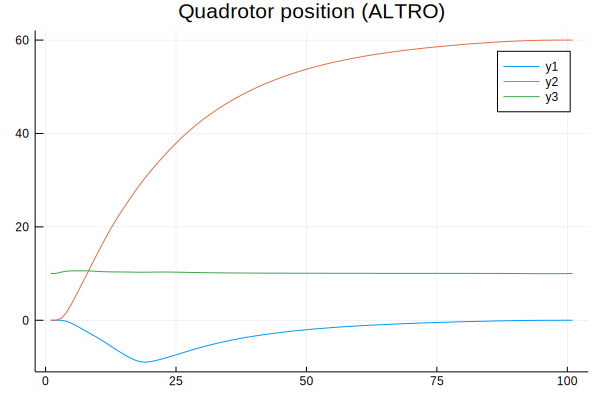

In [5]:
X1 = to_array(p1.X)
plot(X1[1:3,:]',title="Quadrotor position (ALTRO)")

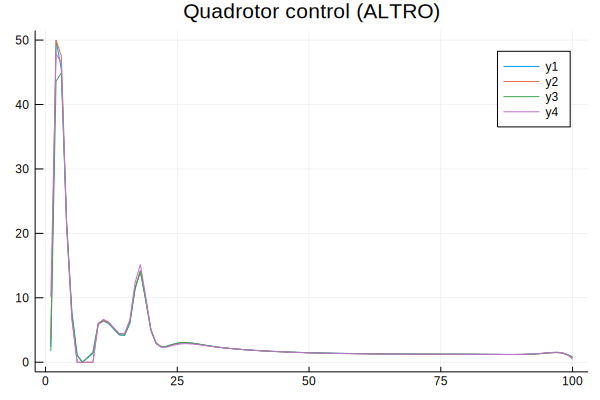

In [6]:
plot(p1.U,title="Quadrotor control (ALTRO)")

In [7]:
# Visualization
function plot_cylinder(vis,c1,c2,radius,mat,name="")
    geom = Cylinder(Point3f0(c1),Point3f0(c2),convert(Float32,radius))
    setobject!(vis["cyl"][name],geom,MeshPhongMaterial(color=RGBA(1, 0, 0, 1.0)))
end

function addcylinders!(vis,cylinders,height=1.5)
    for (i,cyl) in enumerate(cylinders)
        plot_cylinder(vis,[cyl[1],cyl[2],0],[cyl[1],cyl[2],height],cyl[3],MeshPhongMaterial(color=RGBA(0, 0, 1, 1.0)),"cyl_$i")
    end
end

function animate_quadrotor_maze(prob)
    vis = Visualizer()
#     open(vis)
    IJuliaCell(vis)

    traj_folder = joinpath(dirname(pathof(TrajectoryOptimization)),"..")
    urdf_folder = joinpath(traj_folder, "dynamics","urdf")
    obj = joinpath(urdf_folder, "quadrotor_base.obj")

    quad_scaling = 0.7
    robot_obj = FileIO.load(obj)
    robot_obj.vertices .= robot_obj.vertices .* quad_scaling


    sphere_small = HyperSphere(Point3f0(0), convert(Float32,0.25)) # trajectory points
    sphere_med = HyperSphere(Point3f0(0), convert(Float32,0.5));
    sphere_quad = HyperSphere(Point3f0(0), convert(Float32,2.0));


    obstacles = vis["obs"]
    traj = vis["traj"]
    robot = vis["robot"]
    setobject!(vis["robot"]["quad"],robot_obj,MeshPhongMaterial(color=RGBA(0, 0, 0, 1.0)));
    # setobject!(vis["robot"]["ball"],sphere_medium,MeshPhongMaterial(color=RGBA(0, 0, 0, 0.5)));

    settransform!(vis["/Cameras/default"], compose(Translation(0., 72., 60.),LinearMap(RotX(pi/7.5)*RotZ(pi/2))))
    addcylinders!(vis,Problems.quadrotor_maze_objects,16.0)
    traj = vis["traj"]

    for i = 1:prob.N
        setobject!(vis["traj"]["t$i"],sphere_small,MeshPhongMaterial(color=RGBA(0, 1, 0, 1.0)))
        settransform!(vis["traj"]["t$i"], Translation(prob.X[i][1], prob.X[i][2], prob.X[i][3]))
    end

    anim = MeshCat.Animation(24)
    for i = 1:prob.N
        MeshCat.atframe(anim,vis,i) do frame
            settransform!(frame["robot"], compose(Translation(prob.X[i][1:3]...),LinearMap(Quat(prob.X[i][4:7]...))))
        end
    end
    MeshCat.setanimation!(vis,anim)
end

animate_quadrotor_maze (generic function with 1 method)

In [8]:
animate_quadrotor_maze(p1)